In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import bambi
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale

In [2]:
howell = pd.read_csv('./Data/Howell1.csv',sep=';')
howell.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
howell = howell[howell['age'] <= 13]
howell.head()

,height,weight,age,male
18,121.92,19.617854,12.0,1
19,105.41,13.947954,8.0,0
20,86.36,10.489315,6.5,0
23,129.54,23.586784,13.0,1
24,109.22,15.989118,7.0,0


Text(0.5, 1.0, 'Age vs height')

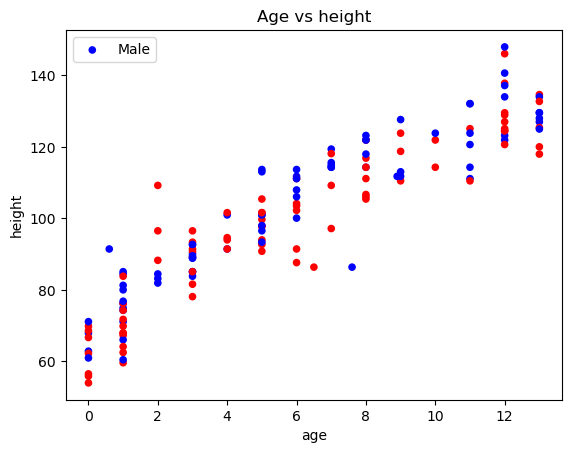

In [4]:
howell.plot.scatter(x='age',y='height',c=howell['male'].map({1:'b',0:'r'}))
plt.legend(['Male','Female'])
plt.title('Age vs height')

A -> H -> W
A -> W 


In [5]:
# Generative Sim 
n=200
A = np.random.normal(0,1,size=n)
H = np.random.normal(0.9*A,size=n)
W = np.random.normal(0.9*A +0.1*H,size=n)

array([[<AxesSubplot: ylabel='Height'>, <AxesSubplot: >],
       [<AxesSubplot: xlabel='Age', ylabel='Weight'>,
        <AxesSubplot: xlabel='Height'>]], dtype=object)

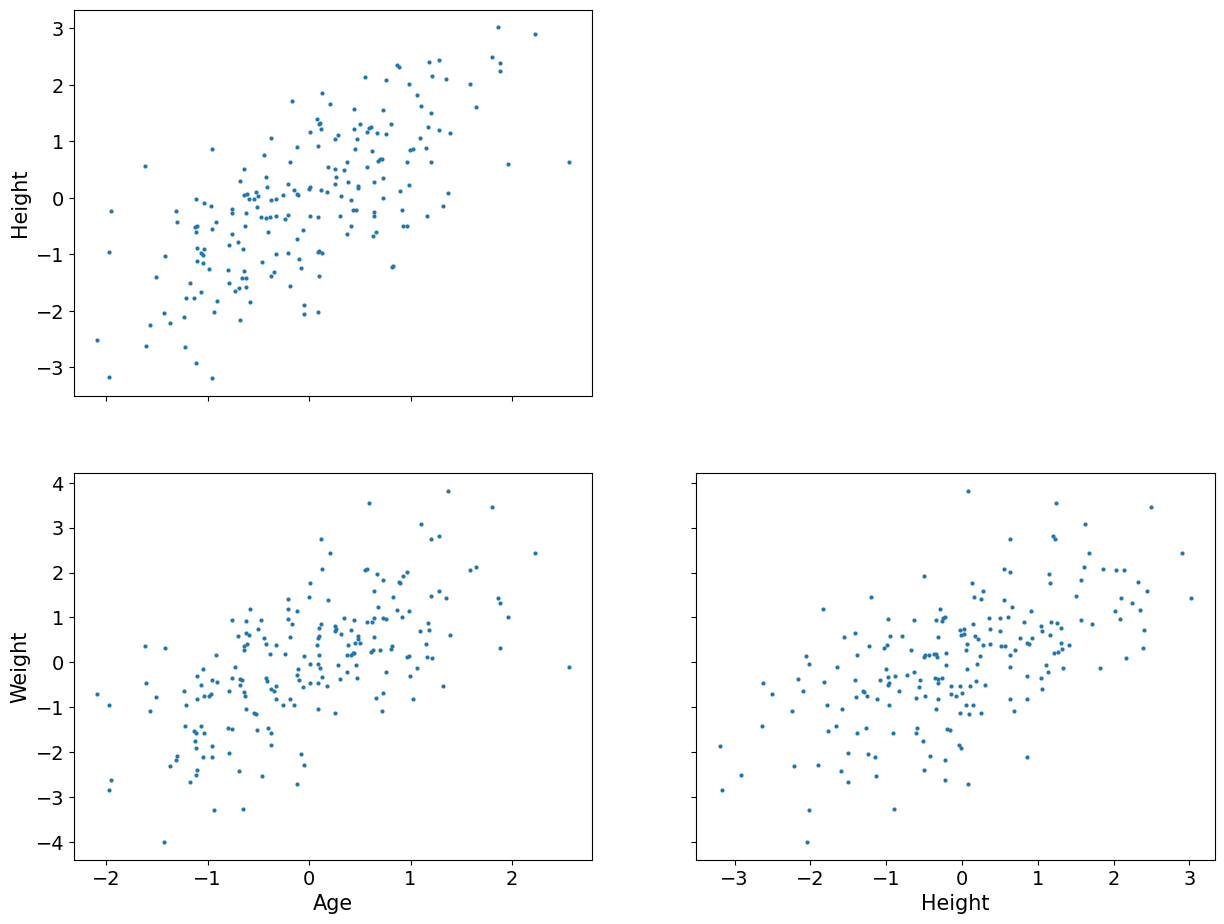

In [6]:
az.plot_pair({'Age':A,'Height':H,'Weight':W})

## Question 2 


In [7]:
A = scale(howell['age'])
W = scale(howell['weight'])
H = scale(howell['height'])

In [8]:
with pm.Model() as total_m: 
    sigma = pm.Exponential('sigma',1)
    bA    = pm.Normal('bA',0,5)
    a     = pm.Normal('a',0,5)
    
    mu = a + bA*howell['age']
    W_est = pm.Normal('W_est',mu,sigma, observed = howell['weight'])
    total_trace = pm.sample()
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
G:\Statistical_Rethinking\rethinking\Lib\site-packages\multipledispatch\dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [9]:
az.summary(total_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bA,1.340,0.049,1.245,1.426,0.001,0.001,2010.0,2268.0,1.0
a,7.420,0.354,6.771,8.083,0.008,0.006,1976.0,2398.0,1.0
sigma,2.563,0.145,2.289,2.825,0.003,0.002,2242.0,2432.0,1.0


## Question 3 

In [10]:
with pm.Model() as sex_m: #Taking into account sex along the way
    sigma = pm.Exponential('sigma',1)
    a     = pm.Normal('a',0,5,shape=2)
    bA    = pm.Normal('bA',0,5,shape=2)
    A     = pm.MutableData('A',howell['age'])
    S     = pm.MutableData('S',howell['male'])
    
    mu    = pm.Deterministic('mu',a[S] +  bA[S]*A)
    
    W_tot = pm.Normal('W_tot',mu,sigma,observed=howell['weight'])
    
    #Finding the diff in sex for later 
    mu_diff = pm.Deterministic('mu_diff', mu[1]-mu[0])
    
    W_diff = pm.Normal('W_diff',mu_diff,sigma, observed = howell['weight'])
    
    sex_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, bA]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [11]:
sex_m

  sigma ~ Exp(f())
      a ~ N(0, 5)
     bA ~ N(0, 5)
     mu ~ Deterministic(f(a, bA))
mu_diff ~ Deterministic(f(a, bA))
  W_tot ~ N(mu, sigma)
 W_diff ~ N(mu_diff, sigma)

In [12]:
az.summary(sex_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],7.785,1.256,5.405,10.106,0.025,0.018,2512.0,2617.0,1.0
a[1],12.156,1.313,9.831,14.694,0.026,0.019,2455.0,2481.0,1.0
bA[0],1.933,0.173,1.608,2.251,0.004,0.003,2349.0,2496.0,1.0
bA[1],-0.162,0.140,-0.425,0.098,0.003,0.002,2431.0,2510.0,1.0
sigma,6.902,0.273,6.429,7.459,0.005,0.003,3111.0,2571.0,1.0
...,...,...,...,...,...,...,...,...,...
mu[153],11.019,0.648,9.827,12.251,0.010,0.007,4082.0,3355.0,1.0
mu[154],9.718,1.114,7.562,11.717,0.022,0.015,2611.0,2651.0,1.0
mu[155],11.994,1.192,9.763,14.186,0.024,0.017,2497.0,2580.0,1.0
mu[156],12.156,1.313,9.831,14.694,0.026,0.019,2455.0,2481.0,1.0


In [13]:
with sex_m:
    
    sex_trace.extend(pm.sample_posterior_predictive(sex_trace))#sex_trace, observed= {'A':1})

Sampling: [W_diff, W_tot]


In [14]:
w_diff_m = sex_trace.posterior_predictive["W_diff"] - np.mean(sex_trace.posterior_predictive["W_diff"])

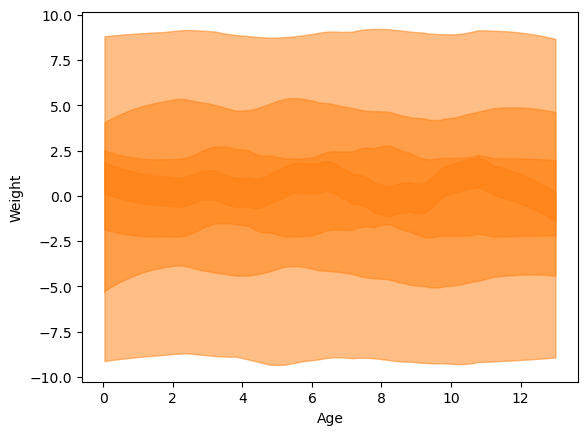

In [17]:
_, ax = plt.subplots()
for hdi in [.10,.25,.50,.81]:
    
    #ax.scatter(howell['age'], sex_trace.observed_data["W_tot"])
    az.plot_hdi(howell['age'], w_diff_m,hdi_prob=hdi)

ax.set_xlabel("Age")
ax.set_ylabel("Weight");

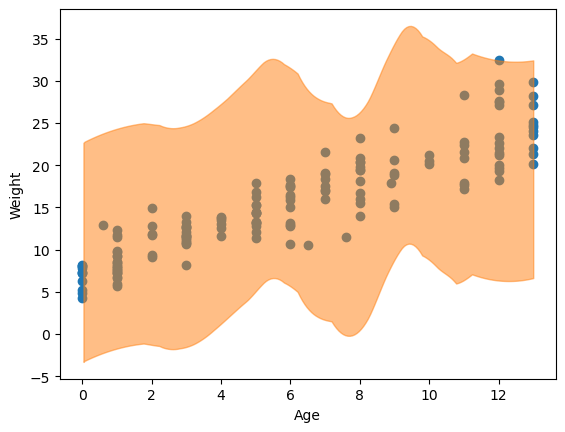

In [16]:
_, ax = plt.subplots()
ax.scatter(howell['age'], sex_trace.observed_data["W_tot"])
az.plot_hdi(howell['age'], sex_trace.posterior_predictive["W_tot"])

ax.set_xlabel("Age")
ax.set_ylabel("Weight");